In [33]:
import statsmodels.api as sm
import pickle
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats
import statsmodels.genmod.generalized_linear_model
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# - inclide color and make

In [34]:
with open('data_with_dummies.pkl', 'rb') as f:
    df = pickle.load(f)

In [35]:

with open('data_no_dummies.pkl', 'rb') as f:
    df_group = pickle.load(f)

In [36]:
df_group.rename(columns={"ticket_number": "ticket_count"}, inplace=True)

In [37]:
df_group_1 = df_group

In [38]:
cols = df_group_1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_group_1 = df_group_1[cols]
df_group_1.head()

,ticket_count,zipcode,weekday_name,population,housing_units,occupied_housing,median_home_value,median_household_income,cbp_employees,q1_payroll_thousands,annual_payroll_thousands,cbp_number_establishments
0,16,90001,Friday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
1,12,90001,Monday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
2,2,90001,Saturday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
3,10,90001,Sunday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
4,27,90001,Thursday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586


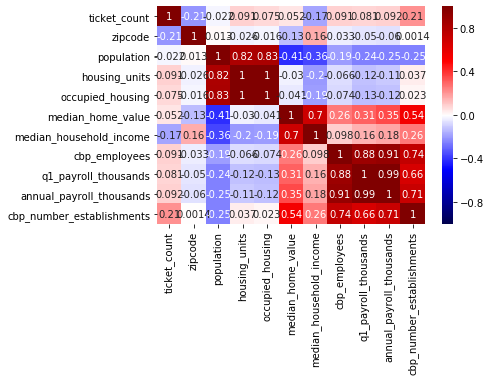

In [39]:
sns.heatmap(df_group_1.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); 

# - drop housing units
# - drop q1 payroll


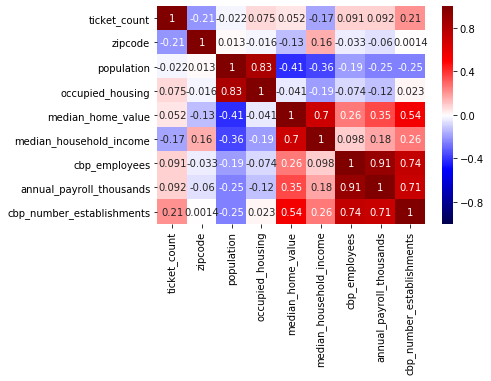

In [40]:
df_group_2 = df_group_1
df_group_2 = df_group_2.drop(['q1_payroll_thousands','housing_units'], axis=1)
sns.heatmap(df_group_2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); 


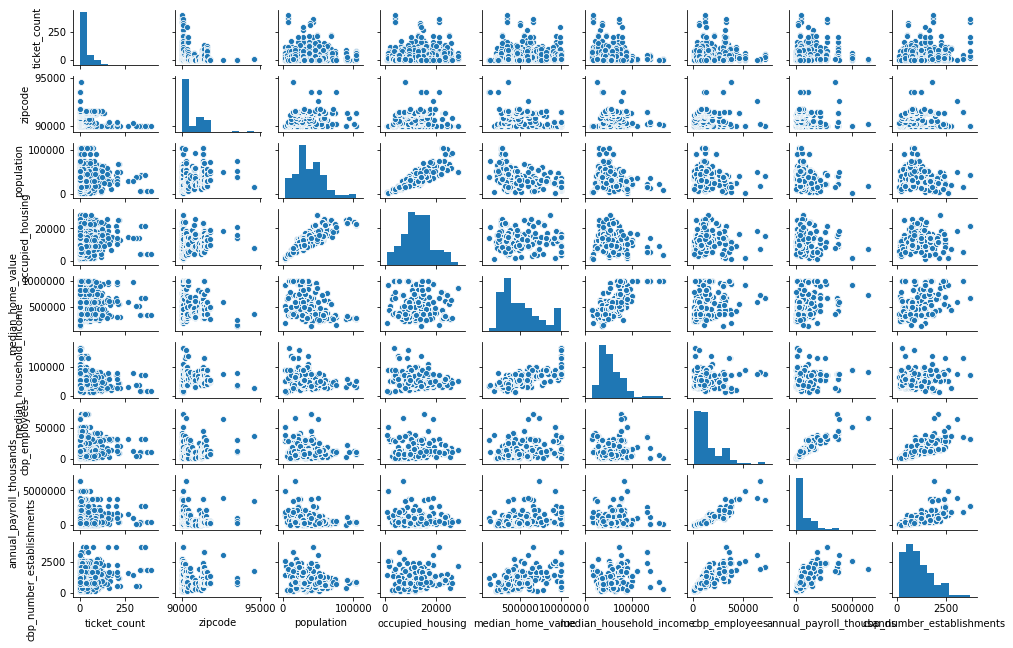

In [41]:
sns.pairplot(df_group_2, height=1.2, aspect=1.5);

# - does not appear to have any polynomial relationships

In [42]:
df_group_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 10 columns):
ticket_count                 848 non-null int64
zipcode                      848 non-null int64
weekday_name                 848 non-null object
population                   848 non-null int64
occupied_housing             848 non-null int64
median_home_value            848 non-null float64
median_household_income      848 non-null float64
cbp_employees                848 non-null int64
annual_payroll_thousands     848 non-null int64
cbp_number_establishments    848 non-null int64
dtypes: float64(2), int64(7), object(1)
memory usage: 66.3+ KB


In [44]:
y_base, X_base = patsy.dmatrices('ticket_count  ~ population + occupied_housing + median_home_value + median_household_income + cbp_employees + annual_payroll_thousands + cbp_number_establishments', data=df_group_2, return_type="dataframe")

# model = sm.GLM(formula="y ~population + population_density + housing_units + occupied_housing + median_home_value + median_household_income + cbp_employees + q1_payroll_thousands + annual_payroll_thousands + cbp_number_establishments", data=df, family=sm.families.Poisson()).fit()




In [45]:
model = sm.GLM(y_base, X_base, family=sm.families.Gamma())

# - https://stats.stackexchange.com/questions/356053/the-identity-link-function-does-not-respect-the-domain-of-the-gamma-family

# - one or more of my intercepts are negative, I need to check my model

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [46]:
results = model.fit()

In [47]:
results.summary()

# p-value below .05 is significant
# pearson chi squared

# population is not significant
# occupied housing is not significant
# median home value is significant. As median home value increases, tickets decrease
# median household income is significant.
# number of employees is significant
# payroll is significant
# number of establishments is significant

# how do I incorporate my day of week data?

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  848
Model:                            GLM   Df Residuals:                      840
Model Family:                   Gamma   Df Model:                            7
Link Function:          inverse_power   Scale:                          1.7991
Method:                          IRLS   Log-Likelihood:                -4057.9
Date:                Thu, 18 Jul 2019   Deviance:                       2834.9
Time:                        10:53:22   Pearson chi2:                 1.51e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0416      0.005      8.507      0.000       0.032       0.051
population                -9.657e-08    1.5e-07     -0.643      0.520   -3.91e-07    1.98e-07
occupied_housing          -7.742e-07   4.34e-07     -1.786      0.074   -1.62e-06    7.56e-08
median_home_value         -8.149e-08   8.56e-09     -9.520      0.000   -9.83e-08   -6.47e-08
median_household_income    1.215e-06   8.49e-08     14.309      0.000    1.05e-06    1.38e-06
cbp_employees              1.181e-06   2.37e-07      4.983      0.000    7.17e-07    1.65e-06
annual_payroll_thousands  -6.988e-09   2.93e-09     -2.388      0.017   -1.27e-08   -1.25e-09
cbp_number_establishments -1.887e-05   1.85e-06    -10.198      0.000   -2.25e-05   -1.52e-05
=============================================================================================
"""

In [122]:
# model_base = results.fittedvalues  # fitted values (need a constant term for intercept)
# model_base_residuals = results.resid # model residuals
# model_base_abs_resid = np.abs(model_residuals)


In [49]:
vif_base_df = df_group_2


In [50]:
vif_base_df = df_group_2.drop(['weekday_name'], axis=1)

In [51]:
# VIF for BASE MODEL
# - to detect multicollinearity

array_vif_base = np.array(vif_base_df)

# vif_base = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 7)
vif_base_population_2 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 2)
vif_base_occupied_housing_3 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 3)
vif_base_median_home_value_4 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 4)
vif_base_median_household_income_5 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 5)
vif_base_employees_6 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 6)
vif_base_annual_payroll_7 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 7)
vif_base_number_busi_8 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 8)


print(vif_base_population_2)
print(vif_base_occupied_housing_3)
print(vif_base_median_home_value_4)
print(vif_base_median_household_income_5)
print(vif_base_employees_6)
print(vif_base_annual_payroll_7)
print(vif_base_number_busi_8)

# vif_base_df.head()


30.461881358514365
38.41089304692702
25.090297393593094
15.061983855150038
17.687694140484652
11.57823327231872
11.797885190431058


## Refinfing Base Model

In [52]:
df_group_3 = df_group_2

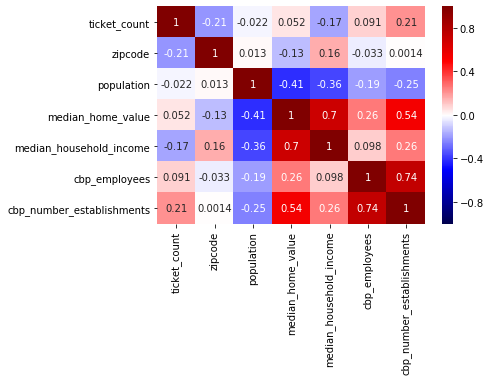

In [53]:
# drop annual payroll - I want to see how many people are working in the area
# drop occupied_housing

df_group_3 = df_group_3.drop(['occupied_housing','annual_payroll_thousands'], axis=1)
sns.heatmap(df_group_3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); 


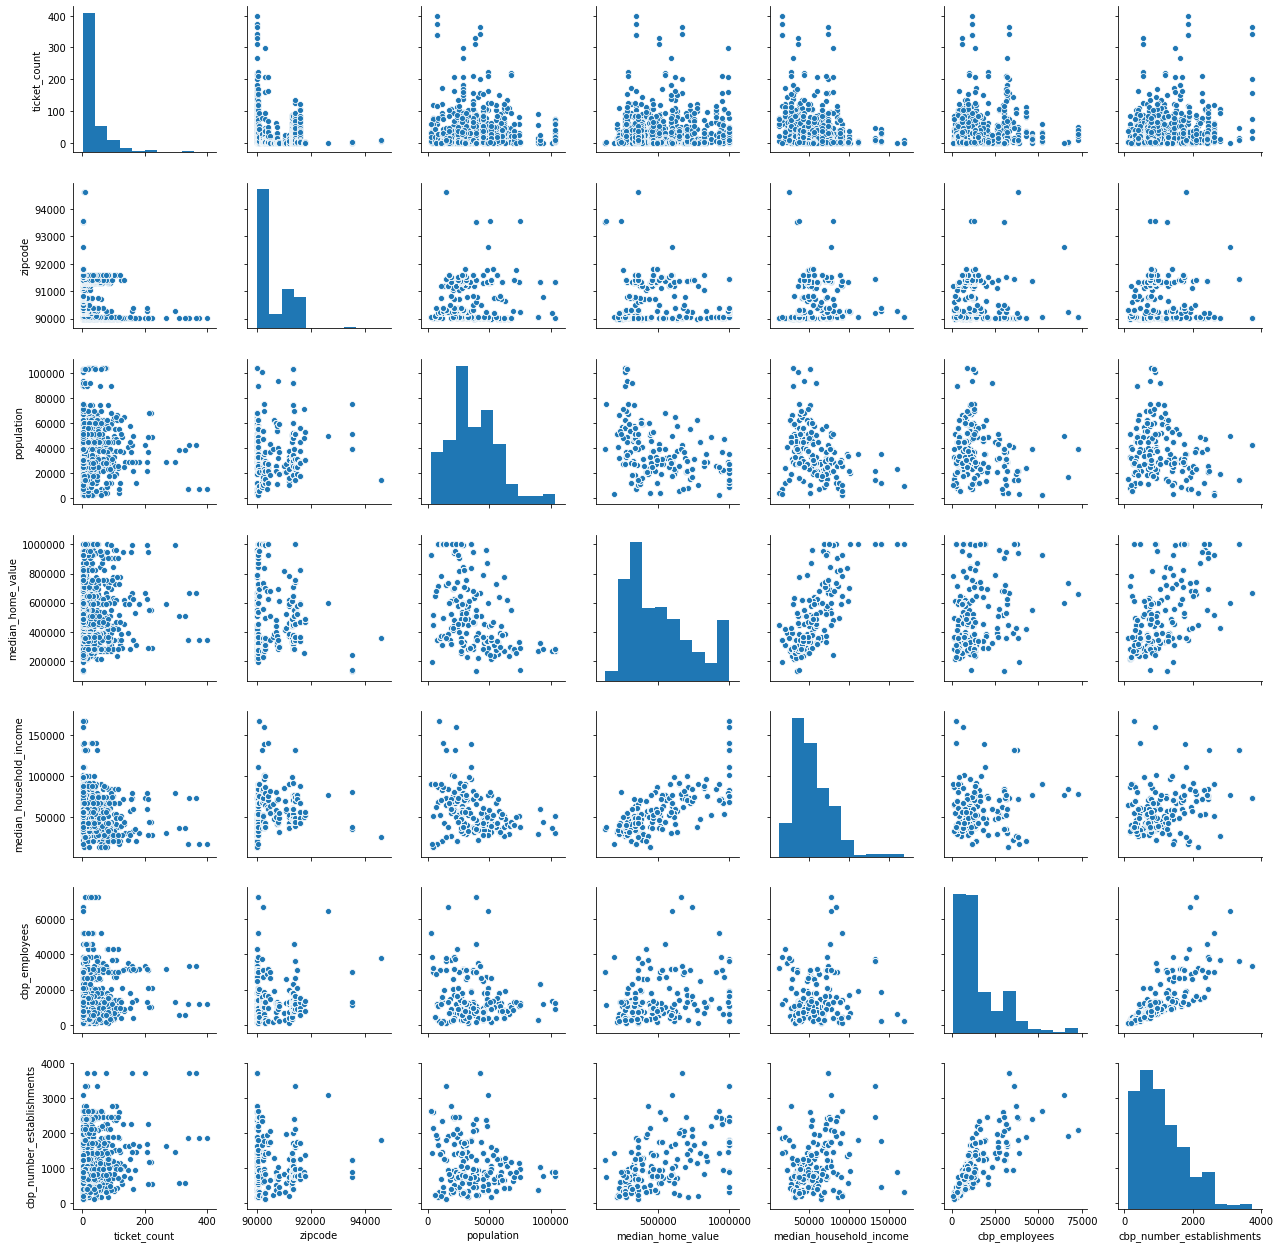

In [54]:
sns.pairplot(df_group_3);


In [55]:
vif_group_3 = df_group_3.drop(['zipcode','weekday_name'], axis=1)
vif_group_3_array = np.array(vif_group_3)

In [56]:
vif_group_3.head()

,ticket_count,population,median_home_value,median_household_income,cbp_employees,cbp_number_establishments
0,16,57110,249600.0,35097.0,10528,586
1,12,57110,249600.0,35097.0,10528,586
2,2,57110,249600.0,35097.0,10528,586
3,10,57110,249600.0,35097.0,10528,586
4,27,57110,249600.0,35097.0,10528,586


In [57]:

vif_3_population_2 = statsmodels.stats.outliers_influence.variance_inflation_factor(vif_group_3_array, 2)
vif_3_median_home_value_3 = statsmodels.stats.outliers_influence.variance_inflation_factor(vif_group_3_array, 3)
vif_3_median_household_income_4 = statsmodels.stats.outliers_influence.variance_inflation_factor(vif_group_3_array, 4)
vif_3_employees_5 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 5)
vif_3_number_busi_6 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_vif_base, 6)


print(vif_3_population_2)
print(vif_3_median_home_value_3)
print(vif_3_median_household_income_4)
print(vif_3_employees_5)
print(vif_3_number_busi_6)



17.112344908600473
12.088224680520495
5.555376564692297
15.061983855150038
17.687694140484652


In [58]:
y_3, X_3 = patsy.dmatrices('ticket_count  ~ population + median_home_value + median_household_income + cbp_employees + cbp_number_establishments', data=df_group_3, return_type="dataframe")


In [59]:
model3 = sm.GLM(y_3, X_3, family=sm.families.Gamma())


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [60]:
results3 = model3.fit()

In [61]:
results3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  848
Model:                            GLM   Df Residuals:                      842
Model Family:                   Gamma   Df Model:                            5
Link Function:          inverse_power   Scale:                          1.8869
Method:                          IRLS   Log-Likelihood:                -4161.3
Date:                Thu, 18 Jul 2019   Deviance:                       3266.4
Time:                        10:54:03   Pearson chi2:                 1.59e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0465      0.004     12.078      0.000       0.039       0.054
population                -2.895e-07   5.04e-08     -5.741      0.000   -3.88e-07   -1.91e-07
median_home_value           -9.7e-08   6.76e-09    -14.351      0.000    -1.1e-07   -8.37e-08
median_household_income    1.287e-06   7.78e-08     16.540      0.000    1.13e-06    1.44e-06
cbp_employees              5.681e-07      1e-07      5.654      0.000    3.71e-07    7.65e-07
cbp_number_establishments  -1.91e-05   1.92e-06     -9.964      0.000   -2.29e-05   -1.53e-05
=============================================================================================
"""

## small business density quotient

In [62]:
bd_base_df = df_group_2

In [63]:


bd_base_df["small_business_quotient"] = bd_base_df["cbp_number_establishments"] / bd_base_df["cbp_employees"] 

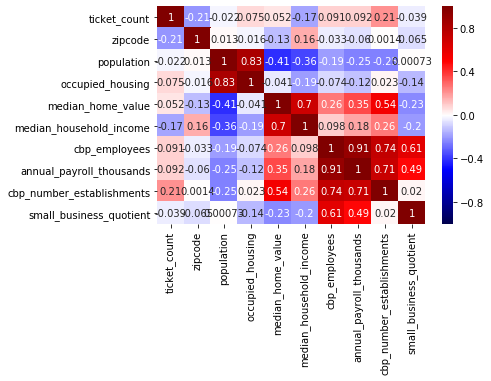

In [64]:
sns.heatmap(bd_base_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); 

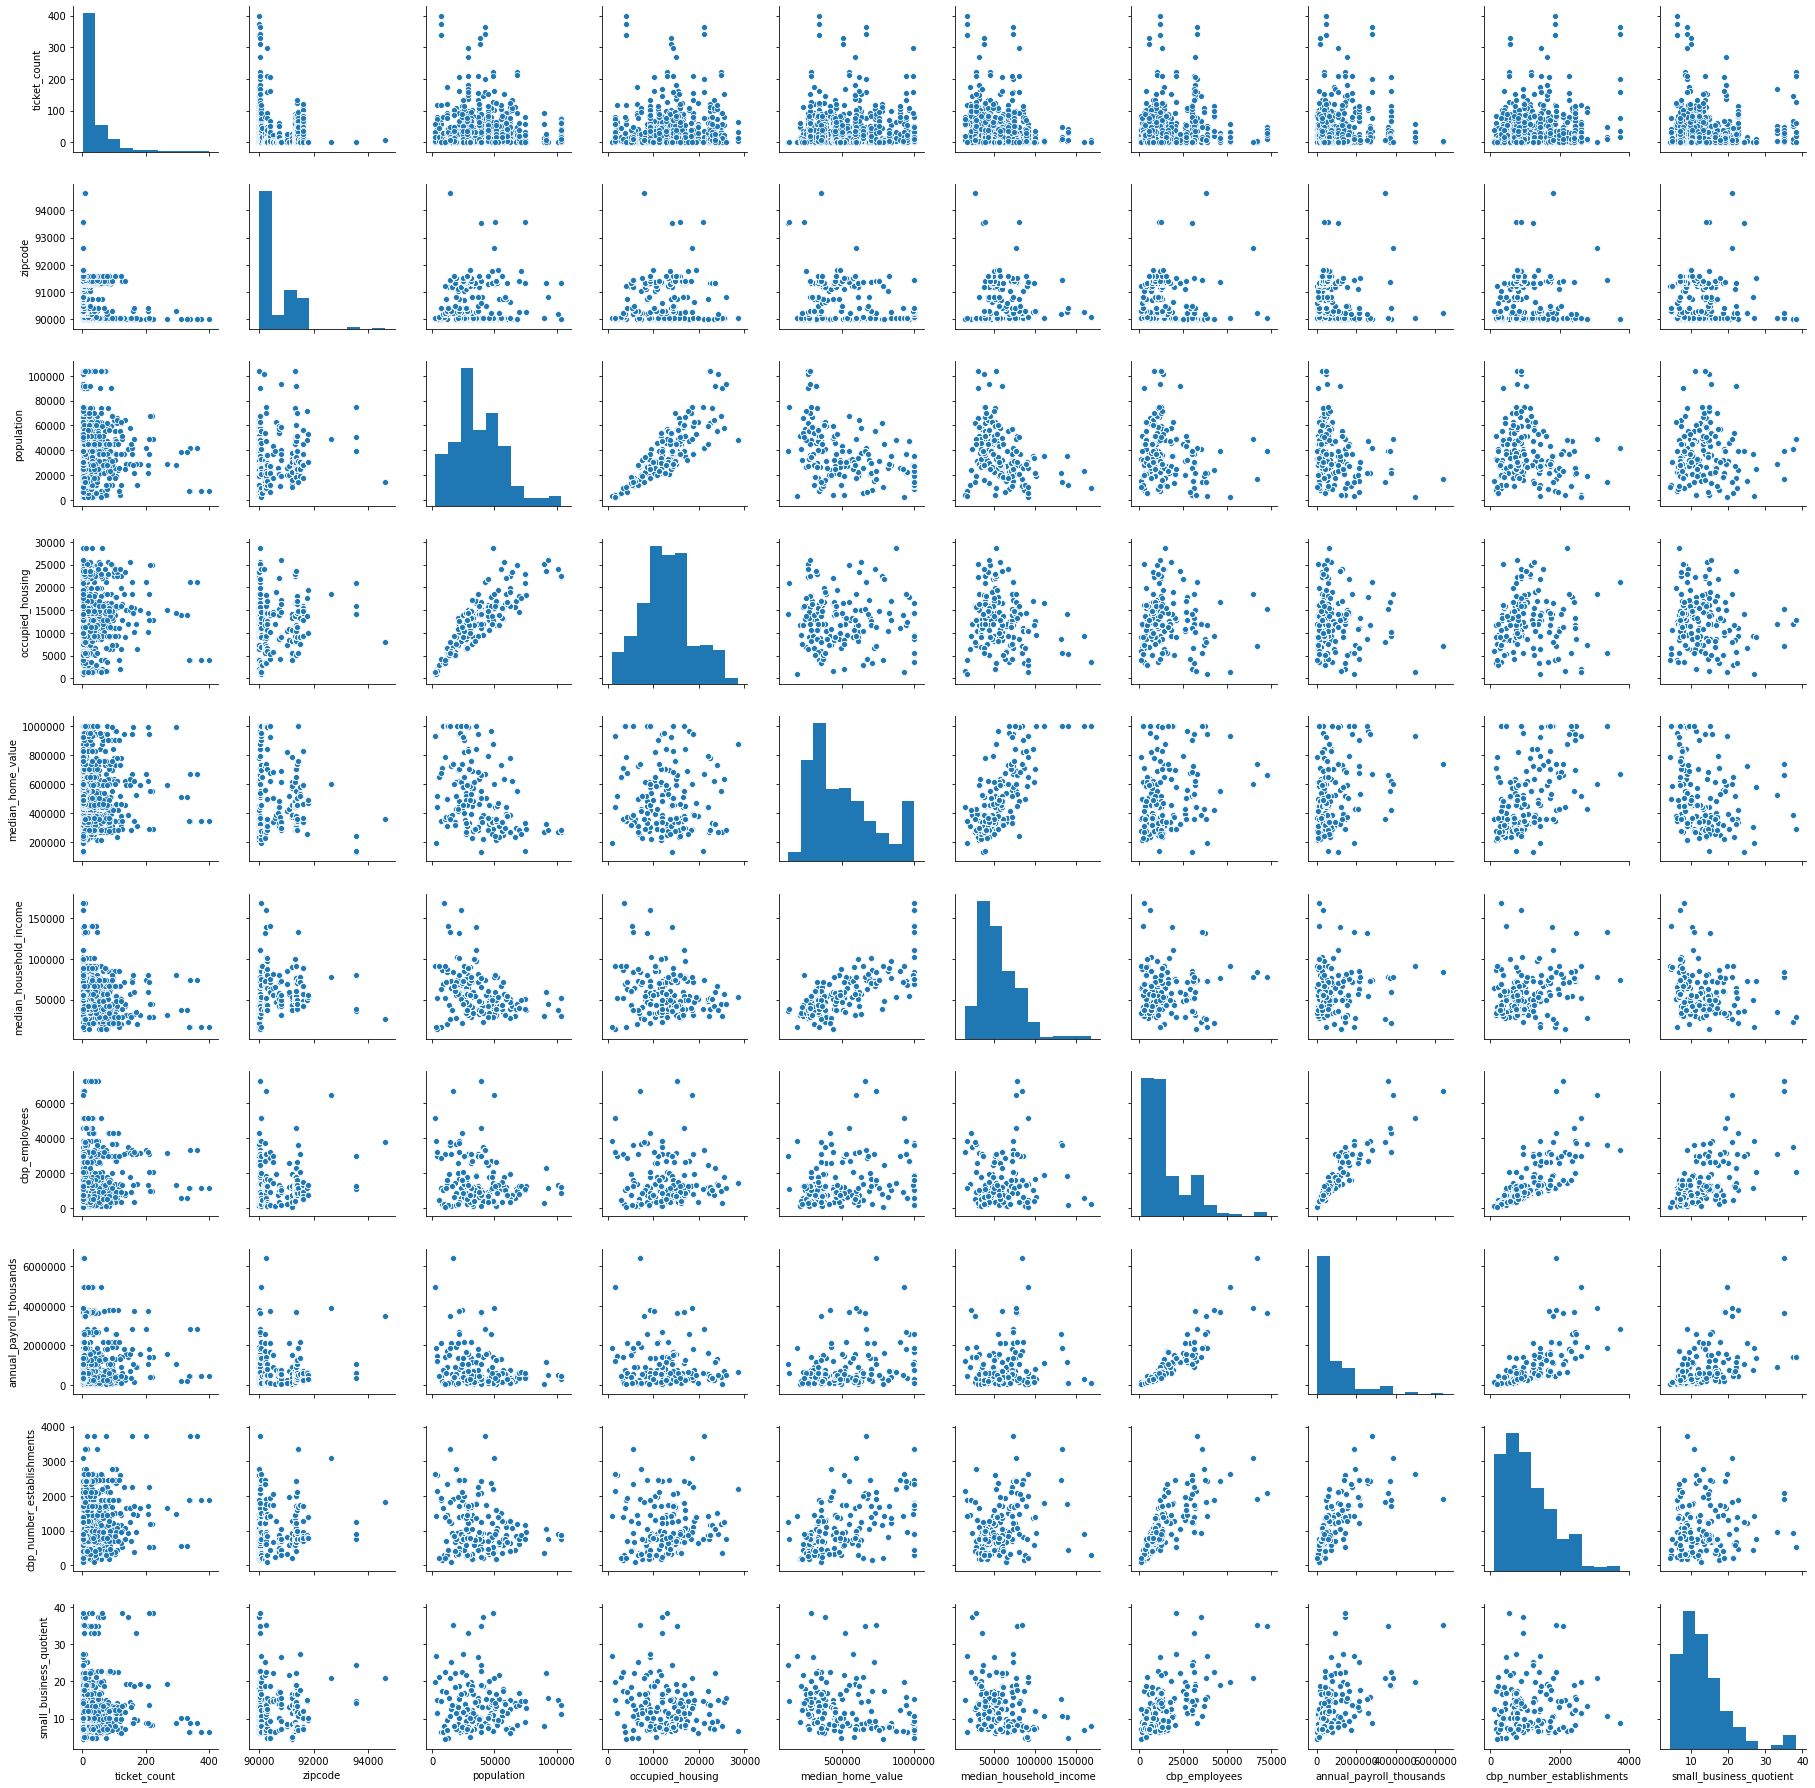

In [65]:
sns.pairplot(bd_base_df);


In [66]:
df_group.cbp_employees.isnull().sum()

0

In [ ]:
# maya@planet.com, nasa develop, student airborn research program

## Weekday

In [67]:
df_group_weekday = df_group

In [68]:
cols = df_group_weekday.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_group_weekday = df_group_weekday[cols]
df_group_weekday.head()

,ticket_count,zipcode,weekday_name,population,housing_units,occupied_housing,median_home_value,median_household_income,cbp_employees,q1_payroll_thousands,annual_payroll_thousands,cbp_number_establishments
0,16,90001,Friday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
1,12,90001,Monday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
2,2,90001,Saturday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
3,10,90001,Sunday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586
4,27,90001,Thursday,57110,13788,12971,249600.0,35097.0,10528,110019,574049,586


In [69]:
dummy_weekday = pd.get_dummies(df_group['weekday_name'])


In [70]:
df_group_weekday = df_group_weekday.merge(dummy_weekday, left_index=True,right_index=True)

In [71]:
df_group_weekday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 19 columns):
ticket_count                 848 non-null int64
zipcode                      848 non-null int64
weekday_name                 848 non-null object
population                   848 non-null int64
housing_units                848 non-null int64
occupied_housing             848 non-null int64
median_home_value            848 non-null float64
median_household_income      848 non-null float64
cbp_employees                848 non-null int64
q1_payroll_thousands         848 non-null int64
annual_payroll_thousands     848 non-null int64
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                 

In [72]:
y, X = patsy.dmatrices('ticket_count  ~ population + occupied_housing + median_home_value + median_household_income + cbp_employees + annual_payroll_thousands + cbp_number_establishments + Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + Sunday', data=df_group_weekday, return_type="dataframe")


In [73]:
model_week = sm.GLM(y, X, family=sm.families.Gamma())


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [74]:
results_week = model_week.fit()

In [75]:
results_week.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  848
Model:                            GLM   Df Residuals:                      834
Model Family:                   Gamma   Df Model:                           13
Link Function:          inverse_power   Scale:                          1.3148
Method:                          IRLS   Log-Likelihood:                -4135.4
Date:                Thu, 18 Jul 2019   Deviance:                       2701.0
Time:                        10:55:05   Pearson chi2:                 1.10e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0436      0.003     15.494      0.000       0.038       0.049
population                 3.735e-07   8.24e-08      4.535      0.000    2.12e-07    5.35e-07
occupied_housing          -1.862e-06   2.18e-07     -8.528      0.000   -2.29e-06   -1.43e-06
median_home_value         -5.373e-08   4.82e-09    -11.147      0.000   -6.32e-08   -4.43e-08
median_household_income    1.023e-06   5.68e-08     18.015      0.000    9.12e-07    1.13e-06
cbp_employees              6.466e-07    6.8e-08      9.504      0.000    5.13e-07     7.8e-07
annual_payroll_thousands  -5.476e-09    6.8e-10     -8.057      0.000   -6.81e-09   -4.14e-09
cbp_number_establishments -1.109e-05   9.64e-07    -11.507      0.000    -1.3e-05    -9.2e-06
Monday                        0.0444      0.009      5.005      0.000       0.027       0.062
Tuesday                      -0.0229      0.002     -9.896      0.000      -0.027      -0.018
Wednesday                    -0.0221      0.002     -9.497      0.000      -0.027      -0.018
Thursday                     -0.0191      0.002     -8.017      0.000      -0.024      -0.014
Friday                       -0.0188      0.002     -7.846      0.000      -0.023      -0.014
Saturday                      0.0612      0.012      5.288      0.000       0.039       0.084
Sunday                        0.0209      0.006      3.372      0.001       0.009       0.033
=============================================================================================
"""

## weekday 2

In [76]:
y_week2, X_week2 = patsy.dmatrices('ticket_count  ~ population + median_home_value + cbp_employees + cbp_number_establishments + Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + Sunday', data=df_group_weekday, return_type="dataframe")


In [77]:
model_week2 = sm.GLM(y_week2, X_week2, family=sm.families.Gamma())


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [78]:
results_week2 = model_week2.fit()

In [79]:
results_week2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  848
Model:                            GLM   Df Residuals:                      837
Model Family:                   Gamma   Df Model:                           10
Link Function:          inverse_power   Scale:                          1.9704
Method:                          IRLS   Log-Likelihood:                -3718.1
Date:                Thu, 18 Jul 2019   Deviance:                       1568.3
Time:                        10:55:12   Pearson chi2:                 1.65e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0559      0.005     11.782      0.000       0.047       0.065
population                -1.468e-07   6.01e-08     -2.441      0.015   -2.65e-07   -2.89e-08
median_home_value          2.201e-08   5.54e-09      3.973      0.000    1.11e-08    3.29e-08
cbp_employees              6.145e-07   1.77e-07      3.479      0.001    2.68e-07    9.61e-07
cbp_number_establishments -2.208e-05   2.83e-06     -7.814      0.000   -2.76e-05   -1.65e-05
Monday                        0.0479      0.011      4.323      0.000       0.026       0.070
Tuesday                      -0.0209      0.003     -6.215      0.000      -0.028      -0.014
Wednesday                    -0.0200      0.003     -5.801      0.000      -0.027      -0.013
Thursday                     -0.0200      0.003     -5.809      0.000      -0.027      -0.013
Friday                       -0.0189      0.004     -5.295      0.000      -0.026      -0.012
Saturday                      0.0653      0.014      4.545      0.000       0.037       0.094
Sunday                        0.0225      0.008      2.829      0.005       0.007       0.038
=============================================================================================
"""

In [ ]:
# bd_base_df["small_business_quotient"] = bd_base_df["cbp_employees"] / bd_base_df["cbp_number_establishments"] 

## Weekday 3

In [80]:
df_group_weekday_3 = df_group_weekday

In [81]:
df_group_weekday_3["small_business_quotient"] = df_group_weekday_3["cbp_number_establishments"]  / df_group_weekday_3["cbp_employees"] 



In [106]:
# df_group_weekday_3 = df_group_weekday_3.drop(['zipcode','weekday_name','housing_units','occupied_housing','median_household_income','q1_payroll_thousands','annual_payroll_thousands'], axis=1)
df_group_weekday_3 = df_group_weekday_3.drop(['cbp_employees'],axis=1)

In [107]:
df_group_weekday_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 12 columns):
ticket_count                 848 non-null int64
population                   848 non-null int64
median_home_value            848 non-null float64
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
small_business_quotient      848 non-null float64
dtypes: float64(2), int64(3), uint8(7)
memory usage: 39.0 KB


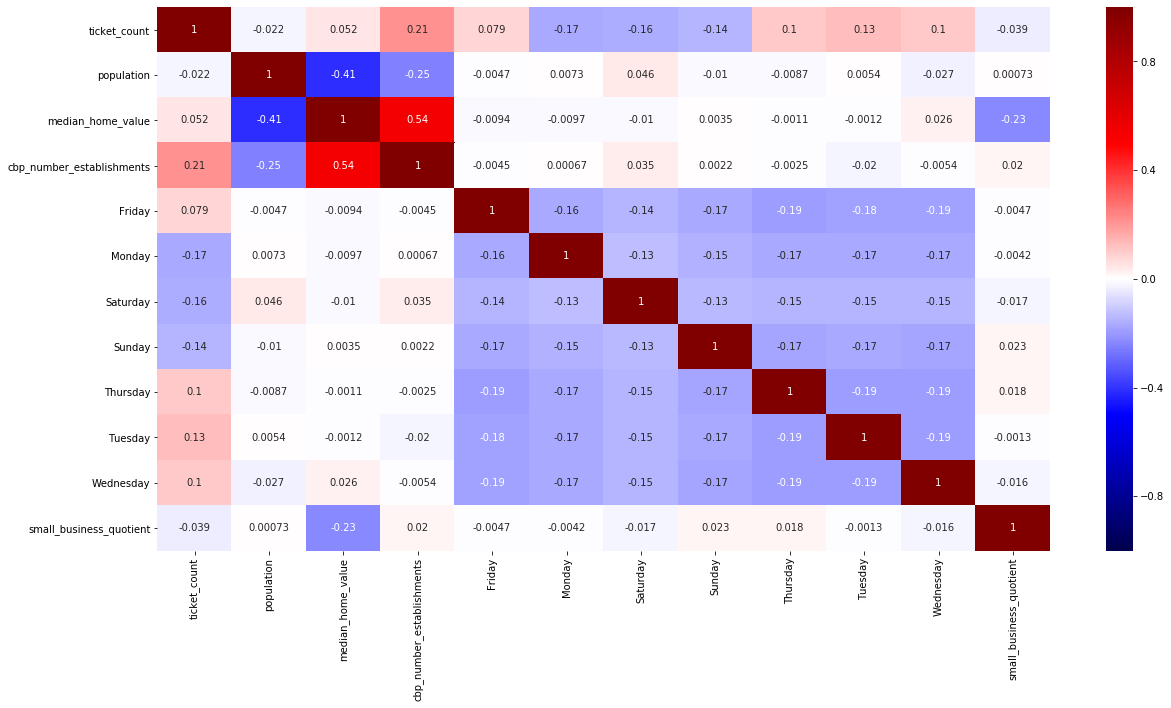

In [108]:
plt.figure(figsize=(20,10))
sns.heatmap(df_group_weekday_3.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1); 

In [109]:
y_week3, X_week3 = patsy.dmatrices('ticket_count  ~ population + median_home_value + cbp_number_establishments + Monday + Tuesday + Wednesday + Thursday + Friday + Saturday + Sunday + small_business_quotient', data=df_group_weekday_3, return_type="dataframe")


In [110]:
model_week3 = sm.GLM(y_week3, X_week3, family=sm.families.Gamma())


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


In [111]:
results_week3 = model_week3.fit(...)

In [112]:
results_week3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  848
Model:                            GLM   Df Residuals:                      837
Model Family:                   Gamma   Df Model:                           10
Link Function:          inverse_power   Scale:                          1.8960
Method:                          IRLS   Log-Likelihood:                -3714.3
Date:                Thu, 18 Jul 2019   Deviance:                       1582.8
Time:                        11:18:01   Pearson chi2:                 1.59e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0521      0.006      9.084      0.000       0.041       0.063
population                -1.535e-07   6.01e-08     -2.556      0.011   -2.71e-07   -3.58e-08
median_home_value          1.754e-08   4.95e-09      3.541      0.000    7.83e-09    2.73e-08
cbp_number_establishments -1.441e-05   1.45e-06     -9.906      0.000   -1.73e-05   -1.16e-05
Monday                        0.0476      0.011      4.361      0.000       0.026       0.069
Tuesday                      -0.0216      0.003     -6.538      0.000      -0.028      -0.015
Wednesday                    -0.0207      0.003     -6.061      0.000      -0.027      -0.014
Thursday                     -0.0207      0.003     -6.072      0.000      -0.027      -0.014
Friday                       -0.0196      0.004     -5.559      0.000      -0.027      -0.013
Saturday                      0.0651      0.014      4.609      0.000       0.037       0.093
Sunday                        0.0221      0.008      2.803      0.005       0.007       0.037
small_business_quotient       0.0005      0.000      2.116      0.034    3.95e-05       0.001
=============================================================================================
"""

In [123]:
y_pred = results_week3.predict(X_val)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

In [116]:
# train - split
# validate
# test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 12 columns):
ticket_count                 848 non-null int64
population                   848 non-null int64
median_home_value            848 non-null float64
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
small_business_quotient      848 non-null float64
dtypes: float64(2), int64(3), uint8(7)
memory usage: 39.0 KB


In [118]:
vif_3_weekday_population_2 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_group_weekday_3, 1)
vif_3__weekday_median_home_value_3 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_group_weekday_3, 2)
vif_3__weekday_business_5 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_group_weekday_3, 3)
vif_3_weekday_quotient_12 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_group_weekday_3, 11)
vif_3_weekday_monday_12 = statsmodels.stats.outliers_influence.variance_inflation_factor(array_group_weekday_3, 5)


print(vif_3_weekday_population_2)
print(vif_3__weekday_median_home_value_3)
# print(vif_3__weekday_employees_4)
print(vif_3__weekday_business_5)
print(vif_3_weekday_quotient_12)
print(vif_3_weekday_monday_12)

1.2233663254630742
1.7879572623157198
1.5672605396931463
1.1123691900733712
4.023976385242811


In [104]:
df_group_weekday_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 13 columns):
ticket_count                 848 non-null int64
population                   848 non-null int64
median_home_value            848 non-null float64
cbp_employees                848 non-null int64
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
small_business_quotient      848 non-null float64
dtypes: float64(2), int64(4), uint8(7)
memory usage: 45.6 KB


In [120]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


X_weekday3, y_weekday3 = df_group_weekday_3.drop('ticket_count',axis=1), df_group_weekday_3['ticket_count']

X_weekday3, X_test, y_weekday3, y_test = train_test_split(X_weekday3, y_weekday3, test_size=.2, random_state=10) #hold out 20% of the data for final testing

#this helps with the way kf will generate indices below
X_weekday3, y_weekday3 = np.array(X_weekday3), np.array(y_weekday3)

In [121]:
kf = KFold(n_splits=5, shuffle=True, random_state = 71)

In [ ]:
#- calcualte RMSE
# RMSE = sqrt(mean((predicted-actual)^2))

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
rmse_list = []

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))

print('Simple regression scores: ', cv_lm_r2s)
print('Ridge scores: ', cv_lm_reg_r2s, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')


In [ ]:
# - i predict that givent he characteristcs of a zipcode, we can predict how many tickets you will get
# - highlight the highest number of tickets per capita
# - which areas have the highest parking tickets given
# - 

In [ ]:
df_group.head()
group_by_week = df_group.groupby(['weekday_name'])['ticket_count'].sum().reset_index()

In [ ]:
group_by_week['percent_of_total'] = (group_by_week['ticket_count'] / 27969) * 100
# total_tickets = group_by_week['ticket_count'].sum()
# total_tickets
group_by_week

# t-test for days of week

In [ ]:
group_by_zipcode = df_group.groupby(['zipcode'])['ticket_count'].sum().reset_index()

In [ ]:
group_by_zipcode['percent_of_total'] = (group_by_zipcode['ticket_count'] / 27969) * 100
group_by_zipcode.sort_values(by='percent_of_total', ascending = False)

## first pass notes

In [ ]:
# -can I still look at the pair plots for correlation, heat map of correlation?
# - variance inflation factor -- look at blog post from Adam
# -what other plots should I make that are unique to count data?
# -- look into condition number if I have time
# - i will check for heterogeneity by checking if there multiple parking citations with the same numer?)
# - overdisbursion check -- confirm variation and mean for each culuster (zip, day of week) - after running the model?

# ------ if this is found, log(y)
# - https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Poisson.html
# - group by zipcode, then day of week



In [ ]:
import pickle
with open('geocode_result_full.pkl', 'rb') as f:
    google_data = pickle.load(f)

In [ ]:
len(google_data)

## overdispursion check

In [ ]:
group_by_zipcode.head()

In [ ]:
group_by_zipcode['ticket_count'].mean()

## train test split

In [124]:
import pandas as pd
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score


In [126]:
df_group_weekday_3_train = df_group_weekday_3

In [128]:
df_group_weekday_3_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 12 columns):
ticket_count                 848 non-null int64
population                   848 non-null int64
median_home_value            848 non-null float64
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
small_business_quotient      848 non-null float64
dtypes: float64(2), int64(3), uint8(7)
memory usage: 39.0 KB


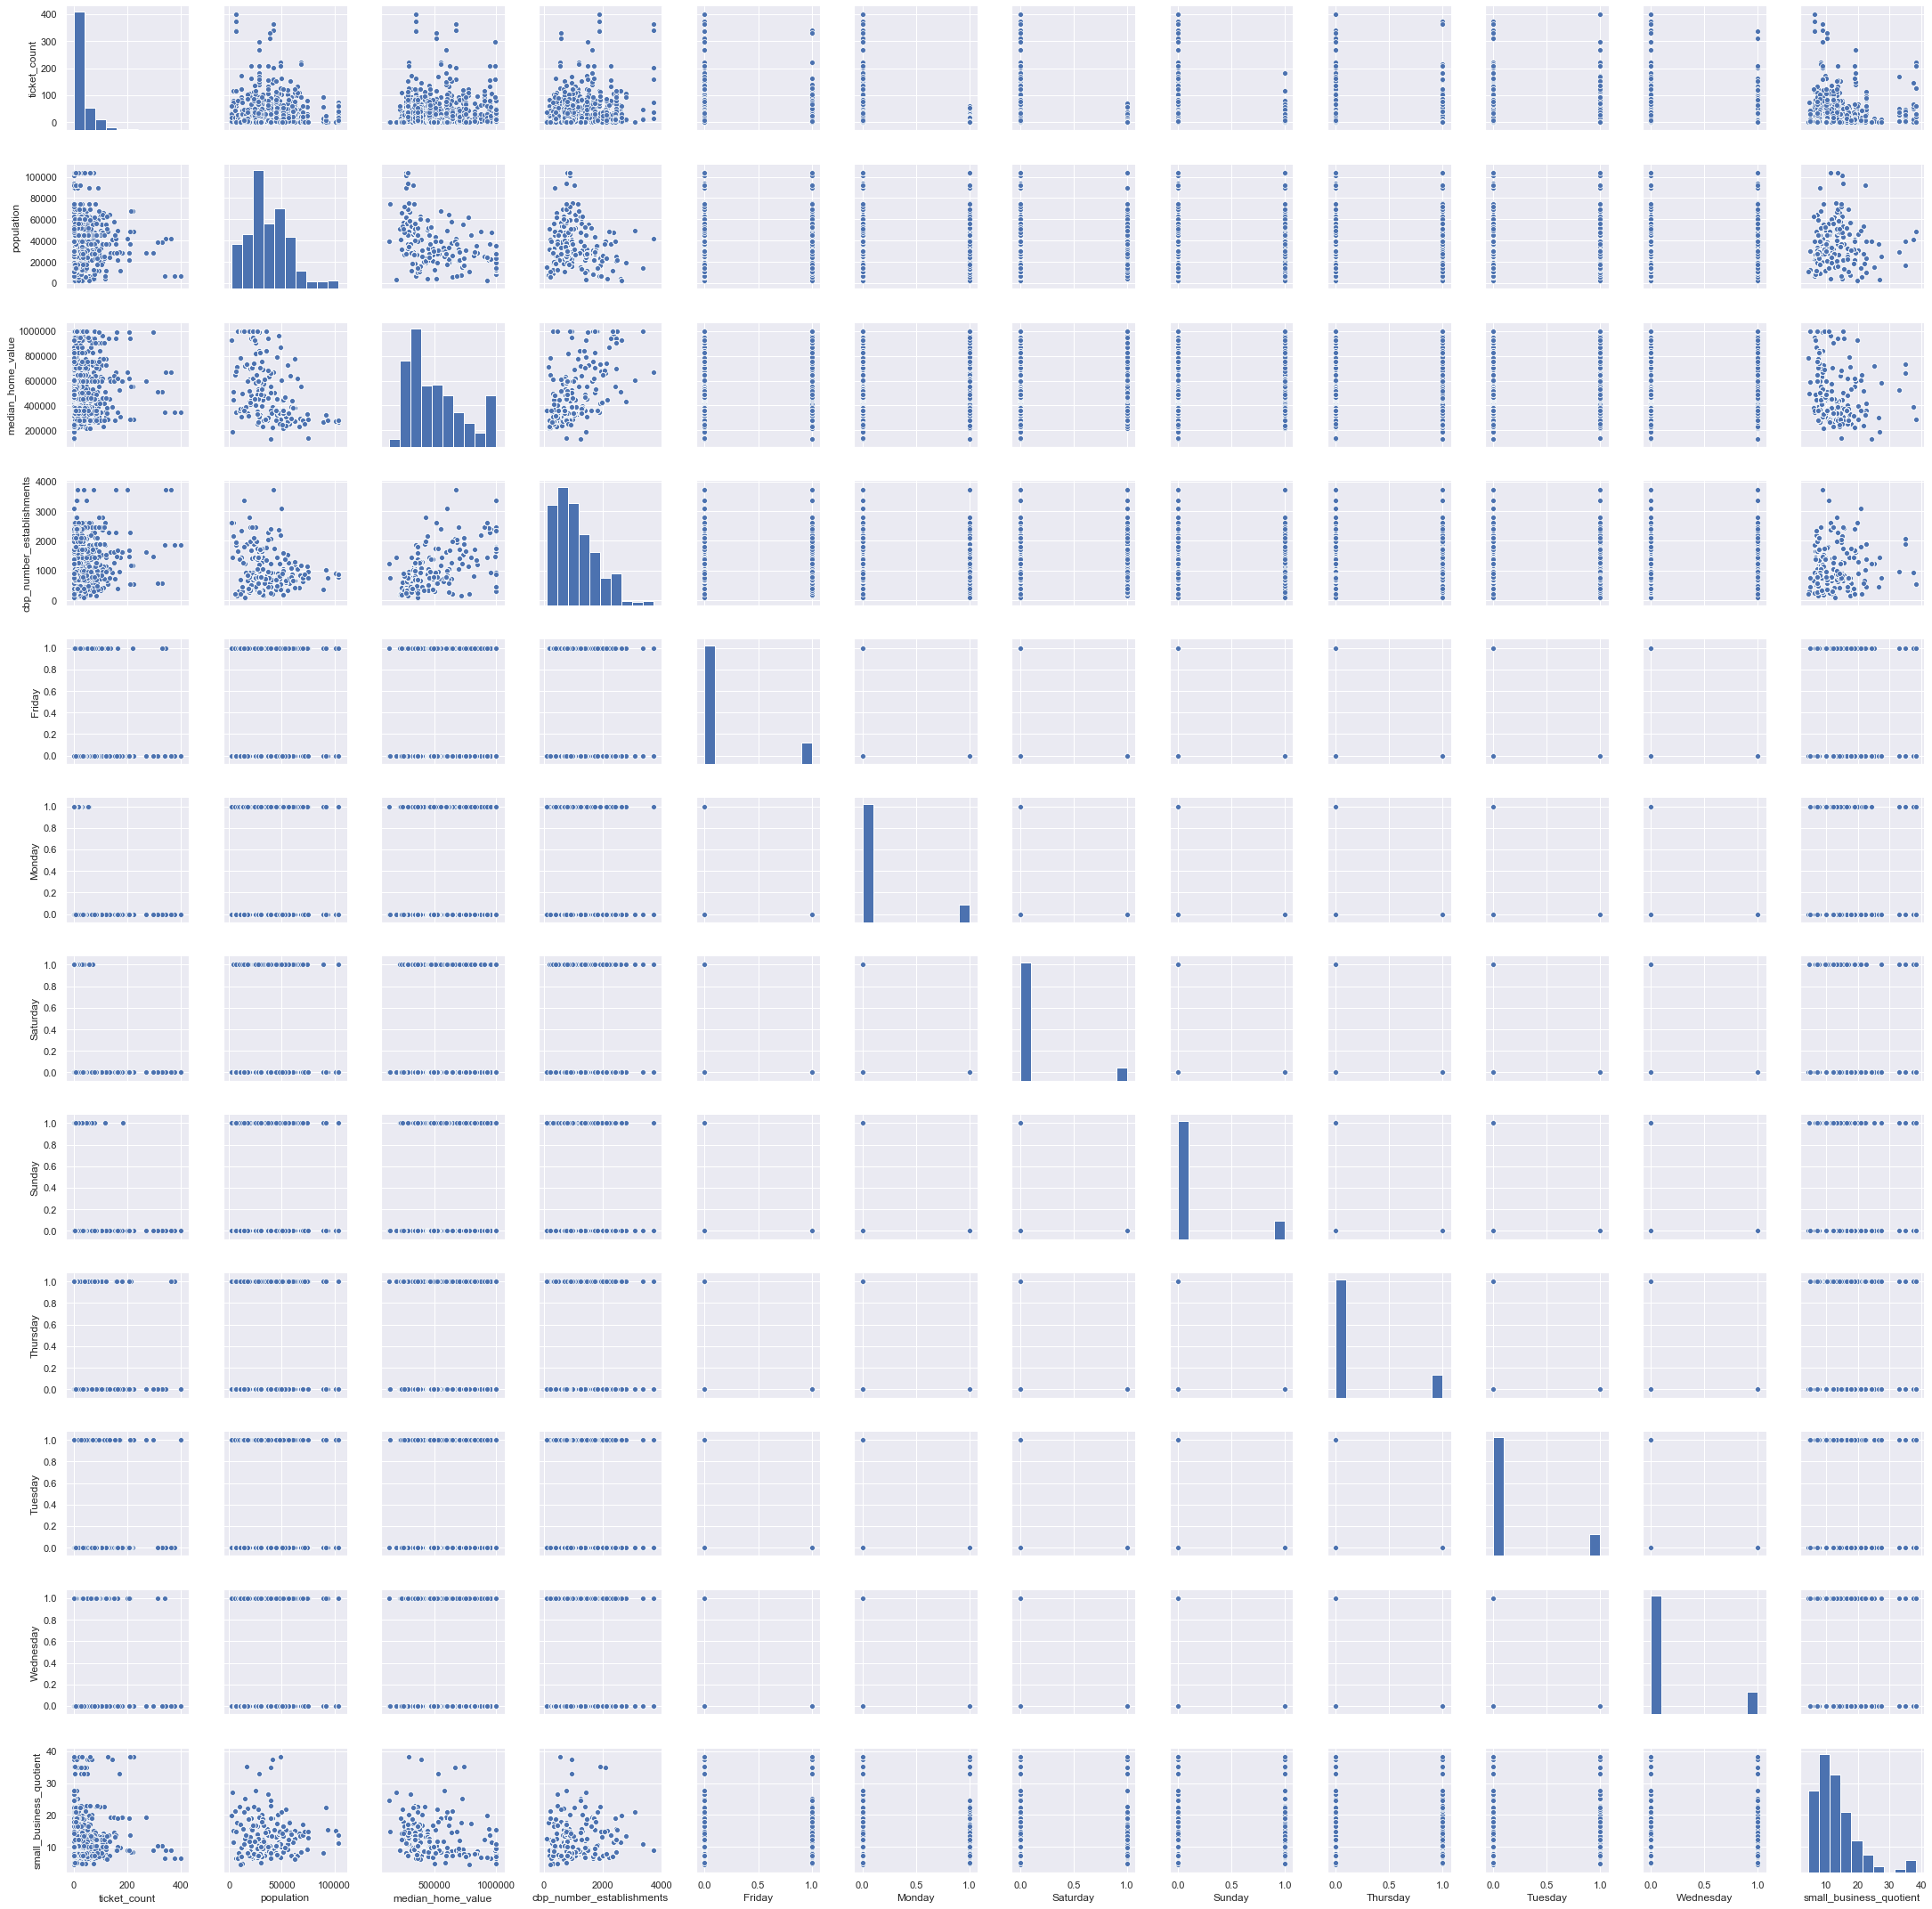

In [129]:
sns.pairplot(df_group_weekday_3_train)

In [130]:
X_weekday = df_group_weekday_3_train.loc[:,['population','cbp_number_establishments',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday',
                                            'small_business_quotient']]
y_weekday = df_group_weekday_3_train['ticket_count']
X_weekday['sq_bus_quo'] = X_weekday['small_business_quotient']**2


In [131]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X_weekday, y_weekday, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)



In [132]:
X_train.columns

Index(['population', 'cbp_number_establishments', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'small_business_quotient', 'sq_bus_quo'],
      dtype='object')

In [133]:
X_train.shape

(508, 11)

In [134]:
X_val.shape

(170, 11)

In [135]:
X_test.shape

(170, 11)

In [136]:
model_train_1 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gamma())
results_train_1 = model_train_1.fit()
results_train_1.summary()


/Users/kathmbell/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  508
Model:                            GLM   Df Residuals:                      497
Model Family:                   Gamma   Df Model:                           10
Link Function:          inverse_power   Scale:                          1.2964
Method:                          IRLS   Log-Likelihood:                -2273.9
Date:                Thu, 18 Jul 2019   Deviance:                       1003.8
Time:                        15:04:43   Pearson chi2:                     644.
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0447      0.006      7.419      0.000       0.033       0.056
population                -7.417e-08   6.59e-08     -1.125      0.261   -2.03e-07     5.5e-08
cbp_number_establishments  -1.42e-05    1.4e-06    -10.145      0.000   -1.69e-05   -1.15e-05
Friday                       -0.0192      0.003     -5.776      0.000      -0.026      -0.013
Monday                        0.0423      0.011      3.962      0.000       0.021       0.063
Saturday                      0.0503      0.013      4.019      0.000       0.026       0.075
Sunday                        0.0290      0.008      3.442      0.001       0.012       0.045
Thursday                     -0.0190      0.003     -5.930      0.000      -0.025      -0.013
Tuesday                      -0.0198      0.003     -6.106      0.000      -0.026      -0.013
Wednesday                    -0.0189      0.003     -5.839      0.000      -0.025      -0.013
small_business_quotient       0.0024      0.001      3.843      0.000       0.001       0.004
sq_bus_quo                -5.848e-05   1.55e-05     -3.782      0.000   -8.88e-05   -2.82e-05
=============================================================================================
"""

In [143]:
from sklearn import metrics

y_pred = results_train_1.predict(sm.add_constant(X_val))
rmse_1 = np.sqrt(metrics.mean_squared_error(y_val,y_pred))

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [144]:
rmse_1

74.52440341118853

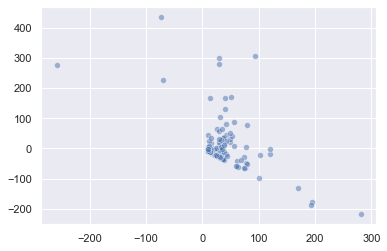

In [147]:
residuals = y_val - y_pred
sns.scatterplot(y_pred, residuals, alpha = .5)


In [148]:
y_val.shape

(170,)

# train 2




In [162]:
X_weekday2 = df_group_weekday_3_train.loc[:,['population','cbp_number_establishments',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday',
                                            'small_business_quotient']]
y_weekday2 = df_group_weekday_3_train['ticket_count']
X_weekday2['sq_bus_quo'] = X_weekday2['small_business_quotient']**2
X_weekday2['pop_log'] = np.log2(X_weekday2['population'])


In [163]:
X_weekday2 = X_weekday2.drop(['population'], axis=1)

In [164]:
X_weekday2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 11 columns):
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
small_business_quotient      848 non-null float64
sq_bus_quo                   848 non-null float64
pop_log                      848 non-null float64
dtypes: float64(3), int64(1), uint8(7)
memory usage: 32.4 KB


In [165]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_weekday2, y_weekday2, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [166]:
model_train_2 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gamma())
results_train_2 = model_train_2.fit()
results_train_2.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  508
Model:                            GLM   Df Residuals:                      497
Model Family:                   Gamma   Df Model:                           10
Link Function:          inverse_power   Scale:                          1.2935
Method:                          IRLS   Log-Likelihood:                -2274.2
Date:                Thu, 18 Jul 2019   Deviance:                       1004.4
Time:                        16:03:40   Pearson chi2:                     643.
No. Iterations:                    12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0551      0.016      3.347      0.001       0.023       0.087
cbp_number_establishments -1.397e-05   1.35e-06    -10.308      0.000   -1.66e-05   -1.13e-05
Friday                       -0.0178      0.004     -4.495      0.000      -0.026      -0.010
Monday                        0.0438      0.011      4.017      0.000       0.022       0.065
Saturday                      0.0518      0.013      4.063      0.000       0.027       0.077
Sunday                        0.0305      0.009      3.509      0.000       0.013       0.048
Thursday                     -0.0175      0.004     -4.538      0.000      -0.025      -0.010
Tuesday                      -0.0182      0.004     -4.706      0.000      -0.026      -0.011
Wednesday                    -0.0174      0.004     -4.455      0.000      -0.025      -0.010
small_business_quotient       0.0024      0.001      3.736      0.000       0.001       0.004
sq_bus_quo                -5.764e-05   1.56e-05     -3.686      0.000   -8.83e-05    -2.7e-05
pop_log                      -0.0010      0.001     -0.884      0.377      -0.003       0.001
=============================================================================================
"""

In [167]:
y_pred = results_train_2.predict(sm.add_constant(X_val))
rmse_2 = np.sqrt(metrics.mean_squared_error(y_val,y_pred))
rmse_2

74.45034451618243

## train 3

In [169]:
X_weekday3 = df_group_weekday_3_train.loc[:,['cbp_number_establishments',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday',
                                            'small_business_quotient']]
y_weekday3 = df_group_weekday_3_train['ticket_count']
X_weekday3['sq_bus_quo'] = X_weekday3['small_business_quotient']**2


In [170]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_weekday3, y_weekday3, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [171]:
model_train_3 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gamma())
results_train_3 = model_train_3.fit()
results_train_3.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  508
Model:                            GLM   Df Residuals:                      498
Model Family:                   Gamma   Df Model:                            9
Link Function:          inverse_power   Scale:                          1.2600
Method:                          IRLS   Log-Likelihood:                -2250.4
Date:                Thu, 18 Jul 2019   Deviance:                       939.92
Time:                        16:04:36   Pearson chi2:                     627.
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0400      0.005      7.789      0.000       0.030       0.050
cbp_number_establishments -1.217e-05   1.07e-06    -11.418      0.000   -1.43e-05   -1.01e-05
Friday                       -0.0161      0.003     -4.800      0.000      -0.023      -0.009
Monday                        0.0414      0.011      3.921      0.000       0.021       0.062
Saturday                      0.0492      0.012      3.982      0.000       0.025       0.073
Sunday                        0.0282      0.008      3.378      0.001       0.012       0.044
Thursday                     -0.0204      0.003     -6.423      0.000      -0.027      -0.014
Tuesday                      -0.0214      0.003     -6.880      0.000      -0.028      -0.015
Wednesday                    -0.0208      0.003     -6.778      0.000      -0.027      -0.015
small_business_quotient       0.0024      0.001      3.708      0.000       0.001       0.004
sq_bus_quo                -5.882e-05   1.59e-05     -3.706      0.000   -8.99e-05   -2.77e-05
=============================================================================================
"""

In [172]:
y_pred = results_train_3.predict(sm.add_constant(X_val))
rmse_3 = np.sqrt(metrics.mean_squared_error(y_val,y_pred))
rmse_3

79.1534216611182

## train 4

In [173]:
X_weekday4 = df_group_weekday_3_train.loc[:,['population','cbp_number_establishments',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday',
                                            'small_business_quotient']]
y_weekday4 = df_group_weekday_3_train['ticket_count']
X_weekday4['sq_bus_quo'] = X_weekday2['small_business_quotient']**2
X_weekday4['pop_log'] = np.log2(X_weekday4['population'])


In [176]:
X_weekday4 = X_weekday4.drop(['population'], axis=1)


In [181]:
X_weekday4 = X_weekday4.drop(['small_business_quotient'], axis=1)


In [182]:
X_weekday4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 10 columns):
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
sq_bus_quo                   848 non-null float64
pop_log                      848 non-null float64
dtypes: float64(2), int64(1), uint8(7)
memory usage: 25.8 KB


In [183]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_weekday4, y_weekday4, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [184]:
model_train_4 = sm.GLM(y_train, sm.add_constant(X_train), family=sm.families.Gamma())
results_train_4 = model_train_4.fit()
results_train_4.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  508
Model:                            GLM   Df Residuals:                      498
Model Family:                   Gamma   Df Model:                            9
Link Function:          inverse_power   Scale:                          1.3696
Method:                          IRLS   Log-Likelihood:                -2275.5
Date:                Thu, 18 Jul 2019   Deviance:                       1020.7
Time:                        16:11:16   Pearson chi2:                     682.
No. Iterations:                    13                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0742      0.016      4.692      0.000       0.043       0.105
cbp_number_establishments  -1.34e-05   1.33e-06    -10.080      0.000    -1.6e-05   -1.08e-05
Friday                       -0.0150      0.004     -3.839      0.000      -0.023      -0.007
Monday                        0.0463      0.011      4.140      0.000       0.024       0.068
Saturday                      0.0551      0.013      4.212      0.000       0.029       0.081
Sunday                        0.0336      0.009      3.773      0.000       0.016       0.051
Thursday                     -0.0151      0.004     -3.872      0.000      -0.023      -0.007
Tuesday                      -0.0153      0.004     -3.905      0.000      -0.023      -0.008
Wednesday                    -0.0154      0.004     -3.846      0.000      -0.023      -0.008
sq_bus_quo                 1.186e-06   5.74e-06      0.207      0.836   -1.01e-05    1.24e-05
pop_log                      -0.0013      0.001     -1.163      0.245      -0.003       0.001
=============================================================================================
"""

In [185]:
y_pred = results_train_4.predict(sm.add_constant(X_val))
rmse_4 = np.sqrt(metrics.mean_squared_error(y_val,y_pred))
rmse_4

73.76222362293609

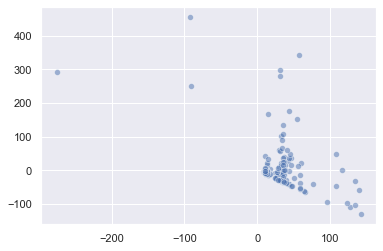

In [186]:
residuals = y_val - y_pred
sns.scatterplot(y_pred, residuals, alpha = .5)

### run on total set

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_weekday4, y_weekday4, test_size=0.2,random_state=42)


In [191]:
model_4 = sm.GLM(y_train_val, sm.add_constant(X_train_val), family=sm.families.Gamma())
results_4 = model_4.fit()
results_4.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  678
Model:                            GLM   Df Residuals:                      668
Model Family:                   Gamma   Df Model:                            9
Link Function:          inverse_power   Scale:                          1.8192
Method:                          IRLS   Log-Likelihood:                -3012.0
Date:                Thu, 18 Jul 2019   Deviance:                       1421.3
Time:                        16:25:36   Pearson chi2:                 1.22e+03
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0904      0.018      4.947      0.000       0.055       0.126
cbp_number_establishments -1.233e-05   1.18e-06    -10.425      0.000   -1.46e-05      -1e-05
Friday                       -0.0114      0.004     -2.587      0.010      -0.020      -0.003
Monday                        0.0524      0.012      4.447      0.000       0.029       0.076
Saturday                      0.0664      0.015      4.453      0.000       0.037       0.096
Sunday                        0.0298      0.009      3.404      0.001       0.013       0.047
Thursday                     -0.0132      0.004     -3.196      0.001      -0.021      -0.005
Tuesday                      -0.0173      0.004     -4.048      0.000      -0.026      -0.009
Wednesday                    -0.0164      0.004     -3.879      0.000      -0.025      -0.008
sq_bus_quo                 6.112e-07   5.37e-06      0.114      0.909   -9.92e-06    1.11e-05
pop_log                      -0.0025      0.001     -1.931      0.054      -0.005    3.85e-05
=============================================================================================
"""

In [192]:
y_pred = results_4.predict(sm.add_constant(X_train_val))
rmse_4_full = np.sqrt(metrics.mean_squared_error(y_train_val,y_pred))
rmse_4_full

69.73768442553535

In [189]:
X_weekday4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 10 columns):
cbp_number_establishments    848 non-null int64
Friday                       848 non-null uint8
Monday                       848 non-null uint8
Saturday                     848 non-null uint8
Sunday                       848 non-null uint8
Thursday                     848 non-null uint8
Tuesday                      848 non-null uint8
Wednesday                    848 non-null uint8
sq_bus_quo                   848 non-null float64
pop_log                      848 non-null float64
dtypes: float64(2), int64(1), uint8(7)
memory usage: 25.8 KB


## SUB ZIPCODES

In [193]:
zip_mask = (df['zipcode'] == 90001 ) | (df['zipcode'] == 90002 ) | (df['zipcode'] == 90003 ) | (
    df['zipcode'] == 90007 ) | (df['zipcode'] == 90008 ) | (df['zipcode'] == 90011 ) | (
    df['zipcode'] == 90015 ) | (df['zipcode'] == 90016 ) | (df['zipcode'] == 90018 ) | (
    df['zipcode'] == 90021 ) | (df['zipcode'] == 90037 ) | (df['zipcode'] == 90043 ) | (
    df['zipcode'] == 90044 ) | (df['zipcode'] == 90047 ) | (df['zipcode'] == 90051 ) | (
    df['zipcode'] == 90052 ) | (df['zipcode'] == 90056 ) | (df['zipcode'] == 90058 ) | (
    df['zipcode'] == 90059 ) | (df['zipcode'] == 90061 ) | (df['zipcode'] == 90062 ) | (
    df['zipcode'] == 90082 ) | (df['zipcode'] == 90089 ) | (df['zipcode'] == 90222 ) | (
    df['zipcode'] == 90232 ) | (df['zipcode'] == 90255 ) | (df['zipcode'] == 90301 ) | (
    df['zipcode'] == 90001 ) | (df['zipcode'] == 90001 ) | (df['zipcode'] == 90001 ) | (
    df['zipcode'] == 90301 ) | (df['zipcode'] == 90302 ) | (df['zipcode'] == 90303 ) | (
    df['zipcode'] == 90305 ) | (df['zipcode'] == 90035 ) | (df['zipcode'] == 90209 ) | (
    df['zipcode'] == 90210 ) | (df['zipcode'] == 90211 ) | (df['zipcode'] == 90212 ) | (
    df['zipcode'] == 90213 ) | (df['zipcode'] == 90272 ) | (df['zipcode'] == 90077 ) 


In [194]:
df_subzipcodes = df_group_weekday_3

In [196]:
df_subzipcodes = df_subzipcodes[zip_mask]

In [197]:
df_subzipcodes.shape

(169, 12)

In [253]:
df_subzipcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 492
Data columns (total 12 columns):
ticket_count                 169 non-null float64
population                   169 non-null float64
median_home_value            169 non-null int64
cbp_number_establishments    169 non-null float64
Friday                       169 non-null float64
Monday                       169 non-null float64
Saturday                     169 non-null float64
Sunday                       169 non-null float64
Thursday                     169 non-null float64
Tuesday                      169 non-null float64
Wednesday                    169 non-null float64
small_business_quotient      169 non-null float64
dtypes: float64(11), int64(1)
memory usage: 22.2 KB


In [259]:
X_subzip_1 = df_subzipcodes.loc[:,['population','median_home_value',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday','small_business_quotient']]
y_subzip_1 = df_subzipcodes['ticket_count']


In [260]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_subzip_1, y_subzip_1, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [268]:
model_subzip_1 = sm.GLM(y_train,X_train, family=sm.families.Gamma())
results_subzip_1 = model_subzip_1.fit()
results_subzip_1.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  101
Model:                            GLM   Df Residuals:                       92
Model Family:                   Gamma   Df Model:                            8
Link Function:          inverse_power   Scale:                          4.5423
Method:                          IRLS   Log-Likelihood:                -484.55
Date:                Thu, 18 Jul 2019   Deviance:                       252.32
Time:                        21:56:41   Pearson chi2:                     418.
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
population                 -0.0006      0.000     -3.563      0.000      -0.001      -0.000
median_home_value        3.639e-08   4.79e-08      0.759      0.448   -5.75e-08     1.3e-07
Friday                      0.1174      0.041      2.888      0.004       0.038       0.197
Monday                      0.1243      0.091      1.363      0.173      -0.054       0.303
Saturday                    0.0962      0.073      1.309      0.190      -0.048       0.240
Sunday                      0.0940      0.054      1.753      0.080      -0.011       0.199
Thursday                    0.0856      0.029      2.981      0.003       0.029       0.142
Tuesday                     0.1057      0.034      3.119      0.002       0.039       0.172
Wednesday                   0.1019      0.037      2.723      0.006       0.029       0.175
small_business_quotient    -0.0006      0.000     -3.563      0.000      -0.001      -0.000
===========================================================================================
"""

In [270]:
X_train_val = np.array(X_train_val)

In [274]:
y_pred = model_subzip_1.predict(X_train_val)
# rmse_sub_1 = np.sqrt(metrics.mean_squared_error(y_train_val,y_pred))
# rmse_sub_1

TypeError: unsupported operand type(s) for -: 'GLM' and 'GLM'

In [265]:
df_subzipcodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 492
Data columns (total 12 columns):
ticket_count                 169 non-null float64
population                   169 non-null float64
median_home_value            169 non-null int64
cbp_number_establishments    169 non-null float64
Friday                       169 non-null float64
Monday                       169 non-null float64
Saturday                     169 non-null float64
Sunday                       169 non-null float64
Thursday                     169 non-null float64
Tuesday                      169 non-null float64
Wednesday                    169 non-null float64
small_business_quotient      169 non-null float64
dtypes: float64(11), int64(1)
memory usage: 22.2 KB


In [276]:
X = df_subzipcodes.loc[:,['population','median_home_value',
                                            'Friday','Monday','Saturday','Sunday',
                                            'Thursday','Tuesday','Wednesday','small_business_quotient']]
y = df_subzipcodes['ticket_count']


In [277]:
model_subzip_1 = sm.GLM(y,sm.add_constant(X), family=sm.families.Gamma())
results_subzip_1 = model_subzip_1.fit()
results_subzip_1.summary()

/Users/kathmbell/anaconda3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:273: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           ticket_count   No. Observations:                  169
Model:                            GLM   Df Residuals:                      160
Model Family:                   Gamma   Df Model:                            8
Link Function:          inverse_power   Scale:                          6.5452
Method:                          IRLS   Log-Likelihood:                -847.55
Date:                Thu, 18 Jul 2019   Deviance:                       635.68
Time:                        22:04:11   Pearson chi2:                 1.05e+03
No. Iterations:                    19                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.1436      0.033      4.314      0.000       0.078       0.209
population                 -0.0007      0.000     -3.951      0.000      -0.001      -0.000
median_home_value       -8.169e-08   4.12e-08     -1.984      0.047   -1.62e-07   -9.86e-10
Friday                      0.0472      0.026      1.827      0.068      -0.003       0.098
Monday                      0.0071      0.047      0.152      0.879      -0.085       0.099
Saturday                    0.0325      0.080      0.405      0.685      -0.125       0.190
Sunday                     -0.0060      0.042     -0.143      0.886      -0.088       0.076
Thursday                    0.0480      0.026      1.850      0.064      -0.003       0.099
Tuesday                     0.0127      0.019      0.666      0.505      -0.025       0.050
Wednesday                   0.0020      0.017      0.118      0.906      -0.032       0.036
small_business_quotient    -0.0007      0.000     -3.951      0.000      -0.001      -0.000
===========================================================================================
"""